In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pdb
%config InlineBackend.figure_formats = ['svg']

## Thermal detector

In [2]:
def det(t, T, C, Gb, Tb, G, P, t0):
    
    dT = P(t, t0)  # heat input
    dT += Gb * (Tb - T)  # coupling to temperature bath
    dT += np.dot(G, T)  # heat transfer from other components
    dT -= np.dot(np.diag(np.dot(G, np.ones(T.shape[0]))),T)  # heat transfer to other components
    dT /= C  # heat to temperature

    return dT

In [6]:
C = np.array([0.1, 
              10.,
              50.])  # heat capacity 
Gb = np.array([100., 
               10.,
               100.]) # heat cond to bath
Tb = 0.  # temp bath
Gab = 10.
Gbc = 1.
G = np.array([[0., Gab, 0.], 
              [Gab, 0., Gbc], 
              [0., Gbc, 0.], ])  # heat cond between components
lamb = 0.01  # thermalization time
eps = 0.1  # share in thermometer
eps_ = np.array([eps, 
                 2*eps, 
                 (1-3*eps)])
t0 = 0.02

def P(x, t0):
    if t0 < x:
        retv = eps_*np.exp(-(x-t0)/lamb) 
    else:
        retv = np.zeros(eps_.shape)
    return retv

t = np.linspace(0,0.1,10000)

T0 = Tb * np.ones(C.shape[0])

In [7]:
%time T = odeint(det, T0, t, args=(C, Gb, Tb, G, P, t0), tfirst=True)

CPU times: user 12.9 ms, sys: 4.46 ms, total: 17.4 ms
Wall time: 13.3 ms


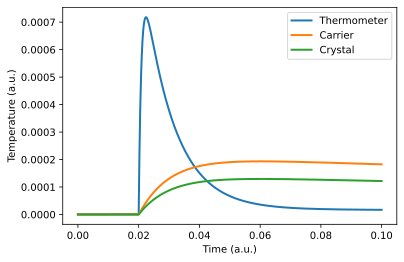

In [8]:
plt.plot(t, T[:, 0], label='Thermometer', c='C0', linewidth=2)
plt.plot(t, T[:, 1], label='Carrier', c='C1', linewidth=2)
plt.plot(t, T[:, 2], label='Crystal', c='C2', linewidth=2)
plt.legend()
plt.xlabel('Time (a.u.)')
plt.ylabel('Temperature (a.u.)')
plt.show()